## 1.1. processing and visualization of control subset

This notebook processes the control subset of the HSPC dataset, clusters the subset and assigns cell type labels to each of the clusters. 

In order to run this notebook make sure the folder `../data/cellranger_output/control/` contains the raw count matrix (`matrix.mtx`), the individual cell barcodes (`barcodes.tsv`) and the gene names (`features.tsv`). Unfortunately these files are to large to be added to the Github repository, so you can download those [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM7084362). 

You will also need the file with the hashtag barcodes for each cell (`hashtags_control.csv`). This file can be found in the Github repository under `../data/hashtags/`.

Note: the cell type labels that we assign to each of the clusters are based on several analyses that we ran. All of those can be found in the scripts 1.2.1-1.2.5.  

In [1]:
### loading python libraries

# standard libraries
import numpy as np
import pandas as pd

# single cell libraries
import anndata as ad
import scanpy as sc
sc.settings.verbosity = 0 

# other 
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore') #ignore filter warnings
import sklearn as sk #used for L2 normalization
import sklearn.preprocessing #used for L2 normalization
import scipy #for transforming matrix from sparse to dense
import os #to get absolute path of file
plt.rcParams['pdf.fonttype'] = 42 #for saving PDF with changeable text
plt.rcParams['ps.fonttype'] = 42 #for saving PDF with changeable text

# import own functions
from utils import *

In [2]:
### load R into Notebook 
%load_ext rpy2.ipython 

### Load datasets
The control subset is loaded into an Anndata object using the path that directs to the folder with the cellranger output files. Afterwards, the hashtags are added to the object. We will also load a set of cell cycle genes. We will remove those cell cycle genes from the data, because we want to avoid cells in a particular state of the cell cycle clustering together in the visualization.

In [3]:
### define cellranger data path
data_path = "../data/cellranger_output/control"

### define hashtag path
hashtag_path = "../data/hashtags/hashtags_control.csv"

In [4]:
### load dataset
adata = sc.read_10x_mtx(path=data_path)
adata

AnnData object with n_obs × n_vars = 3190 × 27998
    var: 'gene_ids', 'feature_types'

In [5]:
### add hashtags to dataset
hashtags = pd.read_csv(hashtag_path, index_col=0)
adata.obs["hashtags"] = hashtags[["hash.ID"]]

In [6]:
### load cell cycle genes
cc_path = "../data/gene_lists/cell_cycle_marker_genes.csv"
cc_markers = pd.read_csv(cc_path, sep=";")
cc_markers = cc_markers["gene"].values
cc_markers = np.unique(cc_markers)

### Filtering
After loading the raw count matrix into an Anndata object, we will filter out cells that do not meet our quality control standards. This includes filtering cells with too many mitochondrial genes, cells with barely any gene expression and finally doublets and negative cells. The latter two categories are identified based on the hashtags. If a cell has no hashtag it is a negative cell and if a cell has more than one hashtag, it is classified as a doublet.

In [7]:
### filter control subset
adata = filter_data(adata, mito_perc=5, min_genes=700, no_doublet=True, no_negative=True)

Trying to set attribute `.obs` of view, copying.


In [8]:
# ### convert matrices from sparse to dense
# print("Converting matrices to dense.")
# #adata.X = adata.X.todense()

In [9]:
### make subset of control; remove cell cycle genes 
adata_hvgs = adata[:,np.setdiff1d(adata.var_names,cc_markers)].copy()

### Find HVGs
Before calculating the dimension reductions and clusters, we will first reduce the size of the dataset from almost 30000 genes to 2000 genes that are the most variable in our dataset (and are therefore probably most important for clustering the cells of different cell types).  

In [10]:
hvgs = get_hvgs(adata_hvgs, no_of_hvgs=500, theta=100)

### Dimension reduction and clustering

Here, we will reduce the dimensions of the control subset and use the Leiden algorithm to cluster the cells.

In [11]:
### select only the HVGs
adata_hvgs = adata_hvgs[:, hvgs]

In [12]:
### L2 normalize control subset
adata_hvgs.X = sk.preprocessing.normalize(adata_hvgs.X, norm='l2')

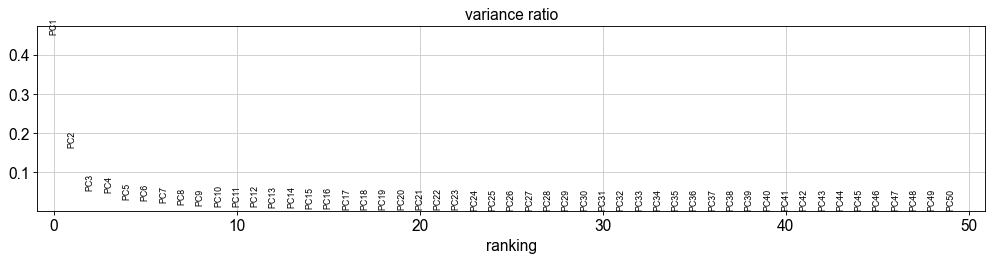

In [13]:
### compute PCA 
sc.set_figure_params(figsize = (15,3))
sc.tl.pca(adata_hvgs, n_comps=50)
sc.pl.pca_variance_ratio(adata_hvgs, n_pcs=50)

In the plot above, we see that almost all variance is captured by the first 10 principal components. To be on the safe side we will take the first 15 principal components to calculate the nearest neighbours graph. 

In [14]:
### calculate NN
sc.pp.neighbors(adata_hvgs, n_neighbors=10, n_pcs=15) 

In [15]:
### calculate UMAP 
sc.tl.umap(adata_hvgs)

In [16]:
### calculate clusters
sc.tl.leiden(adata_hvgs, resolution=0.7, key_added="clusters")

... storing 'hashtags' as categorical


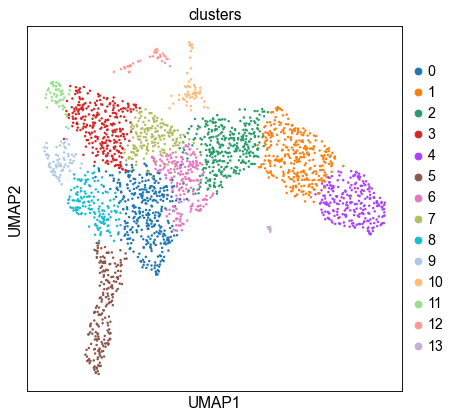

In [17]:
### plot control subset with clusters 
sc.set_figure_params(figsize = (6,6))
sc.pl.umap(adata_hvgs, color="clusters", size=20)

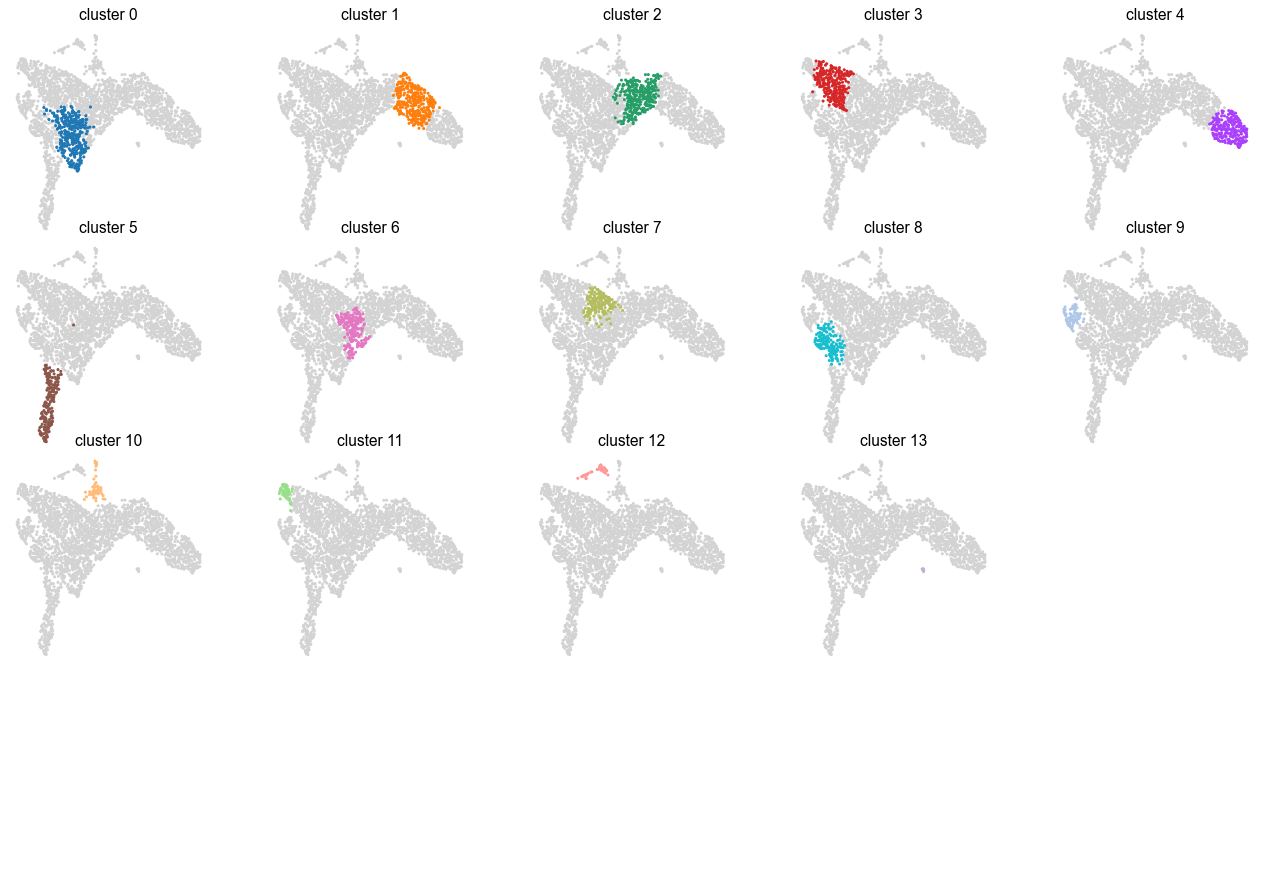

In [18]:
### plot each individual cluster
fig, axs = plt.subplots(4, 5, figsize=(20,14), gridspec_kw={'wspace':0.3, 'hspace':0})

axs = axs.ravel()

for i in adata_hvgs.obs['clusters'].unique():
    sc.pl.umap(adata_hvgs, color = 'clusters', groups=i, 
               size=30, ax=axs[int(i)], show=False, title="cluster "+str(i))
    
for ax in axs:
    ax.axis('off')
    if ax.get_legend(): ax.legend().set_visible(False)

### Label clusters with cell types
Here, we will label each cluster with a cell type. Which cluster represents which cell type is something we explore in notebooks 1.2.1-1.2.4 (looking at DEGs, HVGs, marker genes and overlap with a public dataset). 

In [19]:
### label each cluster with a cell type
old_to_new = {
    "0":'MK prog.',
    "1":'myel. prog. #2',
    "2":'myel. prog. #1',
    "3":'HSCs #2',
    "4":'myel. prog. #3',
    "5":'ery. prog. #3',
    "6":'LMPPs #2',
    "7":'LMPPs #1',
    "8":'ery. prog. #2',
    "9":'ery. prog. #1',
    "10":'eosinophil prog.',
    "11":'HSCs #1',
    "12":'monocytes',
    "13":'eosinophils',
}
adata_hvgs.obs['clusters'] = (
    adata_hvgs.obs['clusters'].map(old_to_new).astype('category'))

In [20]:
### change order of clusters
new_order = ['HSCs #1','HSCs #2',
             'LMPPs #1','LMPPs #2',
             'myel. prog. #1','myel. prog. #2','myel. prog. #3',
             'ery. prog. #1','ery. prog. #2','ery. prog. #3',
             'MK prog.','monocytes',
             'eosinophil prog.','eosinophils']

adata_hvgs.obs["clusters"] = adata_hvgs.obs["clusters"].cat.reorder_categories(new_order)

In [21]:
### change the colors back to new colors
adata_hvgs.uns["clusters_colors"] = [
    '#8c564b','#d62728',
    '#F08D2A','#FEC800',
    '#9ED93F','#4E9639','#203E34',
    '#aec7e8','#17becf','#1f77b4',
    '#CCBFA8','#e377c2',
    '#ff9896','#c5b0d5']

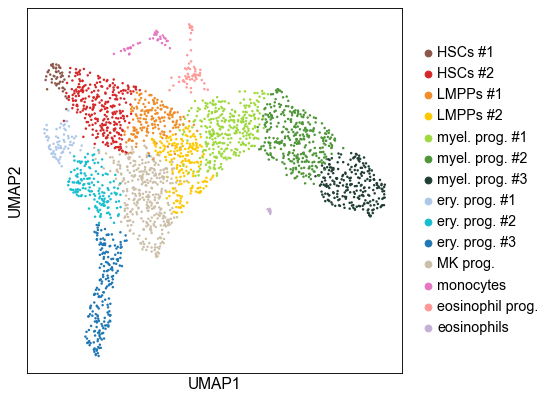

In [22]:
### plot control subset with clusters 
fig, ax = plt.subplots(1,1,figsize=(6,6))
sc.pl.umap(adata_hvgs, color = 'clusters', size=20, 
           ax=ax, show=False, title="")
ax.legend(loc='right', bbox_to_anchor=(1.4, 0.5), ncol=1, frameon=False)
plt.show()

# save figure
save_path = "../figures/1.1.UMAP_control_clusters.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=300)

### Save processed control subset
Now, we will save the control subset in a new file for further downstream analyses. We will save the dataset with all genes (instead of only the HVGs). 

In [23]:
### add clusters and umap to adata too
adata.obs["clusters"] = adata_hvgs.obs["clusters"].values
adata.uns["clusters_colors"] = adata_hvgs.uns["clusters_colors"]
adata.obsm["X_umap"] = adata_hvgs.obsm["X_umap"]
adata

AnnData object with n_obs × n_vars = 2474 × 27998
    obs: 'hashtags', 'clusters'
    uns: 'clusters_colors'
    obsm: 'X_umap'

In [24]:
### save Anndata object
name_file = "control_filtered.h5ad"
adata_path  = f"../data/count_matrices/{name_file}" 
adata.write_h5ad(adata_path)

... storing 'hashtags' as categorical


In [25]:
### save clusters in separate file
name_file = "control_clusters.csv"
save_path  = f"../results/processing/{name_file}" 
adata.obs["clusters"].to_csv(save_path)

### Convert Anndata object to Seurat object
Lastly, we will convert the Anndata object that we saved in data/count_matrices in a .h5ad format to a .h5seurat format. This allows us to use the filtered matrix (with clusters and UMAP assigned) more easily in different R scripts. 

In [26]:
### get absolute path of anndata object
adata_path = os.path.abspath(adata_path)

In [27]:
%%R -i adata_path 

### load packages
library(Seurat) 
library(SeuratDisk)

### load dataset
dataset_dir <- adata_path

### convert h5ad to h5seurat 
Convert(dataset_dir, paste0(tools::file_path_sans_ext(dataset_dir), ".h5seurat"), overwrite = TRUE)

R[write to console]: Attaching SeuratObject

R[write to console]: Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

R[write to console]: Warnung:
R[write to console]:  Unknown file type: h5ad

R[write to console]: Warnung:
R[write to console]:  'assay' not set, setting to 'RNA'

R[write to console]: Creating h5Seurat file for version 3.1.5.9900

R[write to console]: Adding X as data

R[write to console]: Adding X as counts

R[write to console]: Adding meta.features from var

R[write to console]: Adding X_umap as cell embeddings for umap

R[write to console]: Adding clusters_colors to miscellaneous data

